# Лабораторная работа: Регрессионный анализ успеваемости студентов

**Данные:** `student_habits_performance.csv`

Цель лабораторной работы – изучить влияние привычек и образа жизни студентов на их итоговый балл за экзамен с помощью различных моделей линейной регрессии и методов отбора признаков.

## Задачи

1. Загрузить и описать датасет.  
2. Выполнить предобработку данных (обработка пропусков, удаление нерелевантных признаков, нормализация числовых признаков).  
3. Визуализировать:
   * матрицу корреляций (heatmap);
   * взаимосвязь между целевой переменной `exam_score` и каждым из признаков.
4. Разбить данные на обучающую и тестовую выборки.
5. **Этап 1 (без категориальных признаков)**  
   * обучить `LinearRegression`, `Ridge`, `Lasso`, `ElasticNet` (c `GridSearchCV`);  
   * вывести метрики MSE, MAE, R²;  
   * проанализировать коэффициенты.
6. **Этап 2 (с категориальными признаками)**  
   * закодировать категориальные признаки;  
   * пере‑обучить лучшие модели из этапа 1;  
   * сравнить метрики с этапом 1;  
   * провести Recursive Feature Elimination (RFE).
7. Сделать выводы.

In [12]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

# Настройки визуализации
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style='whitegrid', context='notebook')


In [13]:
# Загрузка датасета
df = pd.read_csv('student_habits_performance.csv')

print('Форма датасета:', df.shape)
display(df.head())
display(df.info())

Форма датасета: (1000, 16)


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

None

In [14]:
# Описание признаков
desc = df.describe(include='all').T
display(desc)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
student_id,1000,1000,S1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1000.0,NaN,NaN,NaN,20.498,2.3081,17.0,18.75,20.0,23.0,24.0
gender,1000,3,Female,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
study_hours_per_day,1000.0,NaN,NaN,NaN,3.5501,1.46889,0.0,2.6,3.5,4.5,8.3
social_media_hours,1000.0,NaN,NaN,NaN,2.5055,1.172422,0.0,1.7,2.5,3.3,7.2
netflix_hours,1000.0,NaN,NaN,NaN,1.8197,1.075118,0.0,1.0,1.8,2.525,5.4
part_time_job,1000,2,No,785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attendance_percentage,1000.0,NaN,NaN,NaN,84.1317,9.399246,56.0,78.0,84.4,91.025,100.0
sleep_hours,1000.0,NaN,NaN,NaN,6.4701,1.226377,3.2,5.6,6.5,7.3,10.0
diet_quality,1000,3,Fair,437,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Предобработка данных
# 1. Проверим пропуски
missing = df.isna().sum()
display(missing[missing > 0])

# В текущем датасете пропусков нет. Удалим идентификатор студента, он не информативен
df = df.drop(columns=['student_id'])

# Целевая переменная
TARGET = 'exam_score'

# Определим числовые и категориальные признаки
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(TARGET)
categorical_features = df.select_dtypes(include=['object']).columns

print('Числовые признаки:', list(numeric_features))
print('Категориальные признаки:', list(categorical_features))


parental_education_level    91
dtype: int64

Числовые признаки: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']
Категориальные признаки: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [16]:
# Нормализация числовых признаков (для визуализаций)
df_scaled = df.copy()
scaler_viz = StandardScaler()
df_scaled[numeric_features] = scaler_viz.fit_transform(df[numeric_features])


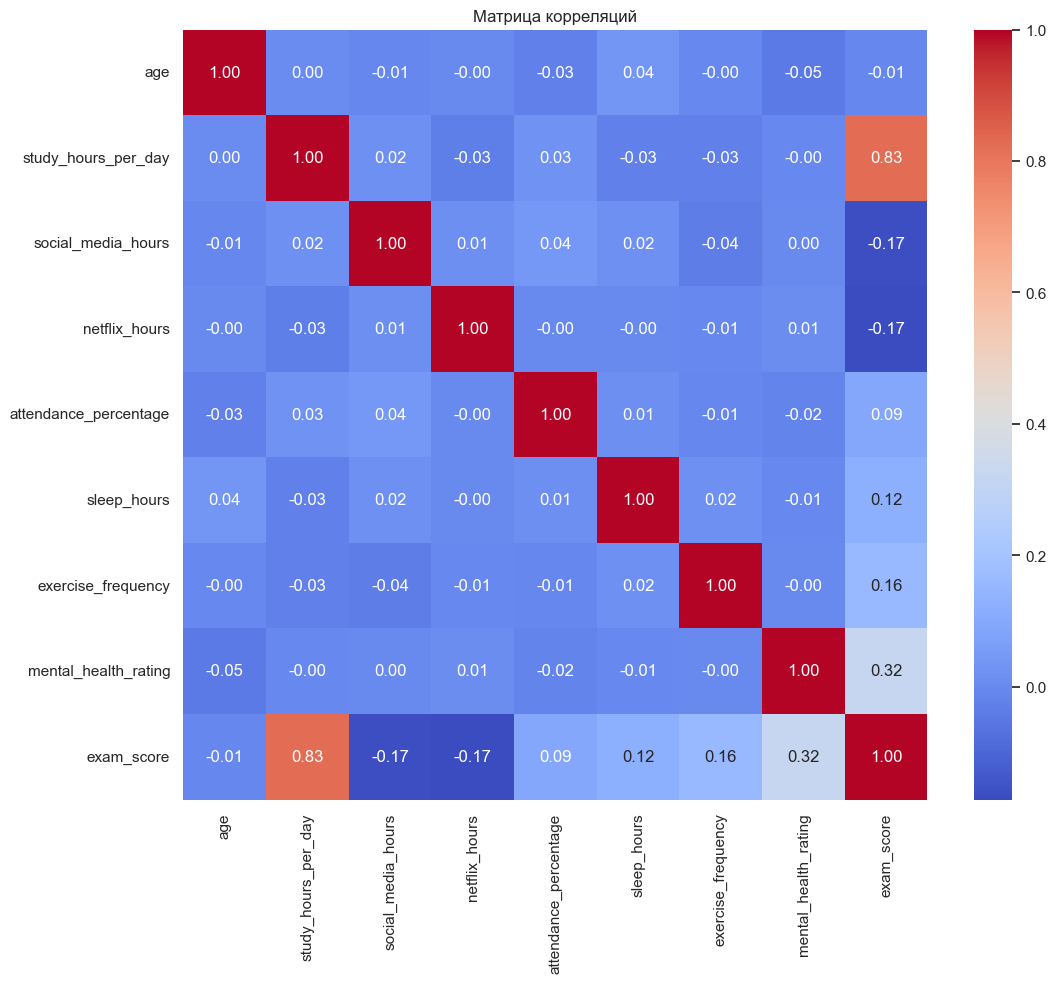

In [17]:
# Корреляционная матрица
plt.figure(figsize=(12,10))
corr = df[numeric_features.tolist() + [TARGET]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()


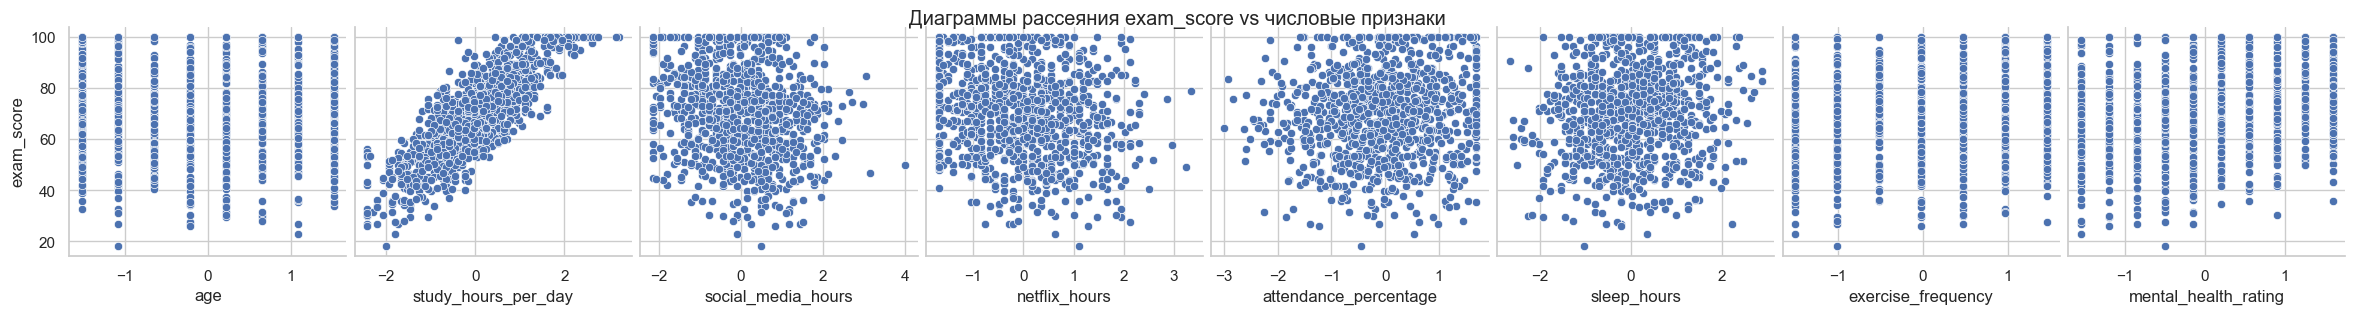

In [18]:
# Взаимосвязь признаков и целевой переменной
g = sns.pairplot(data=df_scaled, y_vars=[TARGET], x_vars=numeric_features, height=3, aspect=1)
g.fig.suptitle('Диаграммы рассеяния exam_score vs числовые признаки', y=1.02)
plt.show()


In [19]:
# Разделение на обучающую и тестовую выборки
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

# Сохраним копии с категориальными признаками для этапа 2
X_train_full = X_train.copy()
X_test_full  = X_test.copy()

# На этапе 1 используем только числовые признаки
X_train_num = X_train[numeric_features]
X_test_num  = X_test[numeric_features]

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)


Train shape: (800, 14)
Test shape : (200, 14)



LinearRegression
MSE : 25.921
MAE : 4.130
R^2 : 0.899


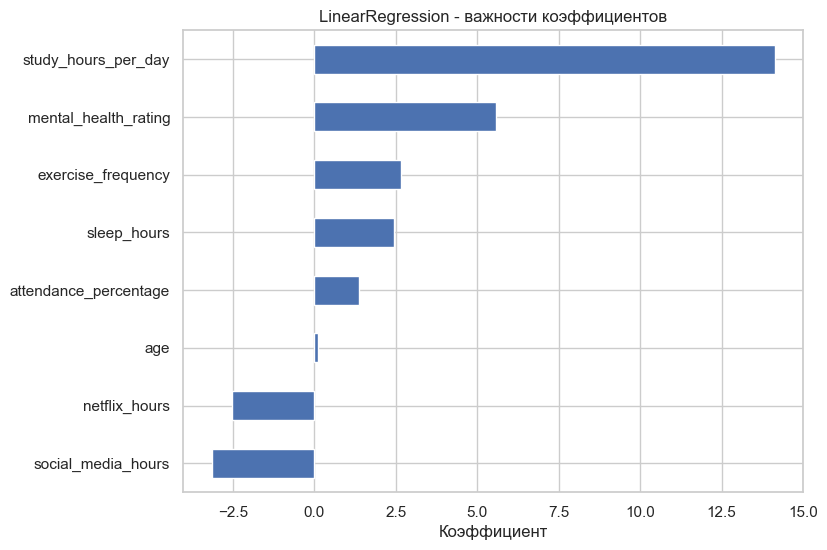

In [20]:
# ===== ЭТАП 1. Линейная регрессия без категориальных признаков =====
def regression_report(model, X_tr, y_tr, X_te, y_te, name='Model'):
    y_pred = model.predict(X_te)
    mse = mean_squared_error(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    r2  = r2_score(y_te, y_pred)
    print(f'\n{name}')
    print(f'MSE : {mse:.3f}')
    print(f'MAE : {mae:.3f}')
    print(f'R^2 : {r2:.3f}')
    return {'name': name, 'model': model, 'MSE': mse, 'MAE': mae, 'R2': r2}

lin_reg = LinearRegression()
lin_reg.fit(X_train_num_scaled, y_train)
report_lin = regression_report(lin_reg, X_train_num_scaled, y_train, X_test_num_scaled, y_test, 'LinearRegression')

# Коэффициенты
coef_series = pd.Series(lin_reg.coef_, index=numeric_features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
coef_series.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('LinearRegression - важности коэффициентов')
plt.xlabel('Коэффициент')
plt.show()



Best params for Ridge: {'alpha': 1.2742749857031335}

Best params for Lasso: {'alpha': 0.01}

Best params for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.9}

Ridge
MSE : 25.940
MAE : 4.132
R^2 : 0.899


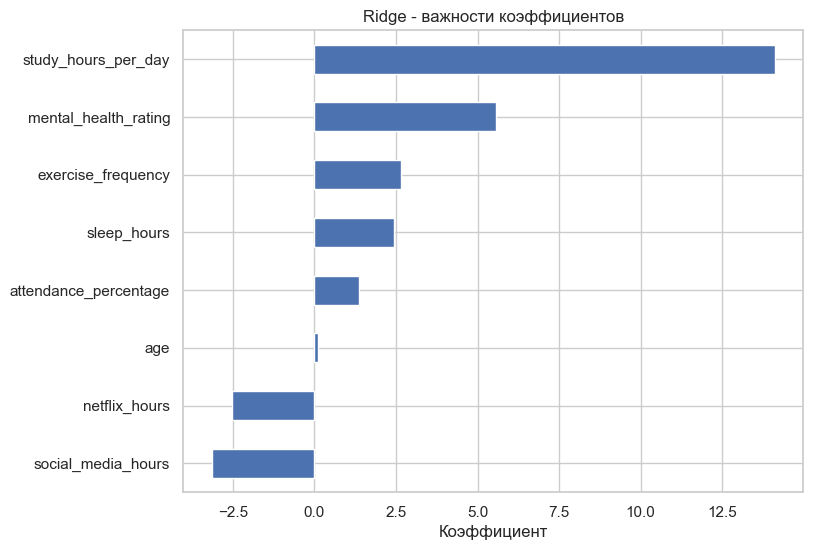


Lasso
MSE : 25.927
MAE : 4.131
R^2 : 0.899


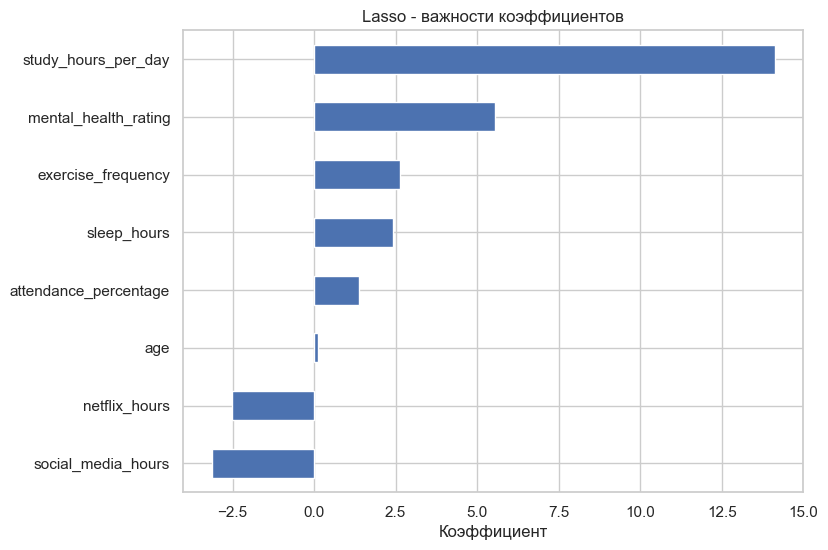


ElasticNet
MSE : 25.938
MAE : 4.132
R^2 : 0.899


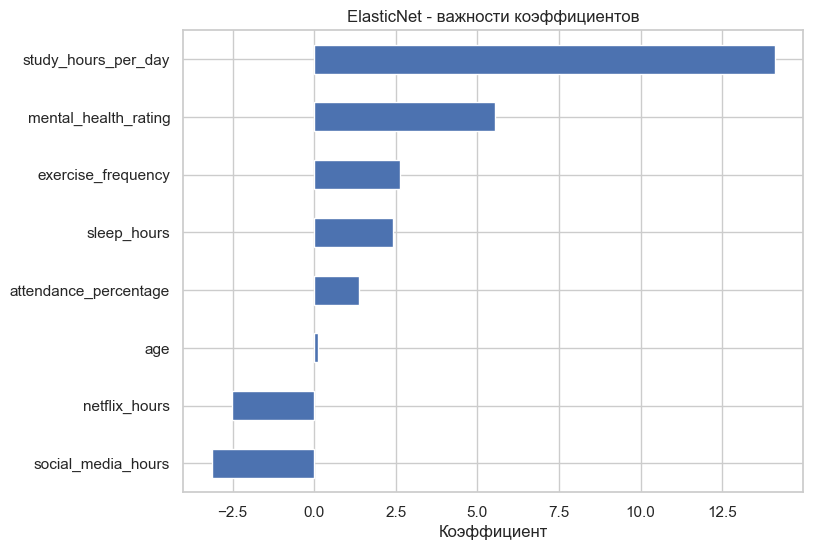

In [21]:
# Ridge, Lasso, ElasticNet с GridSearchCV
param_ridge = {'alpha': np.logspace(-2, 2, 20)}
param_lasso = {'alpha': np.logspace(-2, 2, 20)}
param_enet  = {'alpha': np.logspace(-2, 2, 10),
               'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

ridge_gs = GridSearchCV(Ridge(), param_ridge, cv=5, scoring='neg_mean_squared_error')
lasso_gs = GridSearchCV(Lasso(max_iter=10000), param_lasso, cv=5, scoring='neg_mean_squared_error')
enet_gs  = GridSearchCV(ElasticNet(max_iter=10000), param_enet, cv=5, scoring='neg_mean_squared_error')

for gs, name in zip([ridge_gs, lasso_gs, enet_gs], ['Ridge', 'Lasso', 'ElasticNet']):
    gs.fit(X_train_num_scaled, y_train)
    print(f'\nBest params for {name}:', gs.best_params_)

ridge_best = ridge_gs.best_estimator_
lasso_best = lasso_gs.best_estimator_
enet_best  = enet_gs.best_estimator_

reports_stage1 = []
for model, name in zip([ridge_best, lasso_best, enet_best], ['Ridge', 'Lasso', 'ElasticNet']):
    rep = regression_report(model, X_train_num_scaled, y_train, X_test_num_scaled, y_test, name)
    reports_stage1.append(rep)

    coef_series = pd.Series(model.coef_, index=numeric_features).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    coef_series.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f'{name} - важности коэффициентов')
    plt.xlabel('Коэффициент')
    plt.show()


In [28]:
# ===== ЭТАП 2. Работа с категориальными признаками =====
# Препроцессор: масштабируем числовые и one‑hot кодируем категориальные признаки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),  # ← заменили параметр
        categorical_features)
    ]
)


# helper to build pipeline with given model
def make_pipe(model):
    return Pipeline(steps=[('preprocess', preprocessor),
                           ('model', model)])

# --- готовим словари «чистых» гиперпараметров без max_iter ---
ridge_params = ridge_best.get_params()                    # у Ridge всё ок
lasso_params = {k: v for k, v in lasso_best.get_params().items()
                if k != 'max_iter'}                       # убрали max_iter
enet_params  = {k: v for k, v in enet_best.get_params().items()
                if k != 'max_iter'}                       # убрали max_iter

# --- строим пайплайны ---
models_stage2 = {
    'LinearRegression': make_pipe(LinearRegression()),
    'Ridge'          : make_pipe(Ridge(**ridge_params)),
    'Lasso'          : make_pipe(Lasso(max_iter=10000, **lasso_params)),
    'ElasticNet'     : make_pipe(ElasticNet(max_iter=10000, **enet_params))
}



reports_stage2 = []

for name, pipe in models_stage2.items():
    pipe.fit(X_train_full, y_train)
    y_pred = pipe.predict(X_test_full)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f'\n{name} (with categorical features)')
    print(f'MSE : {mse:.3f}')
    print(f'MAE : {mae:.3f}')
    print(f'R^2 : {r2:.3f}')
    reports_stage2.append({'name': name, 'model': pipe, 'MSE': mse, 'MAE': mae, 'R2': r2})



LinearRegression (with categorical features)
MSE : 26.476
MAE : 4.189
R^2 : 0.897

Ridge (with categorical features)
MSE : 26.492
MAE : 4.190
R^2 : 0.897

Lasso (with categorical features)
MSE : 26.449
MAE : 4.185
R^2 : 0.897

ElasticNet (with categorical features)
MSE : 26.462
MAE : 4.186
R^2 : 0.897



Лучшая модель (этап 2): Lasso


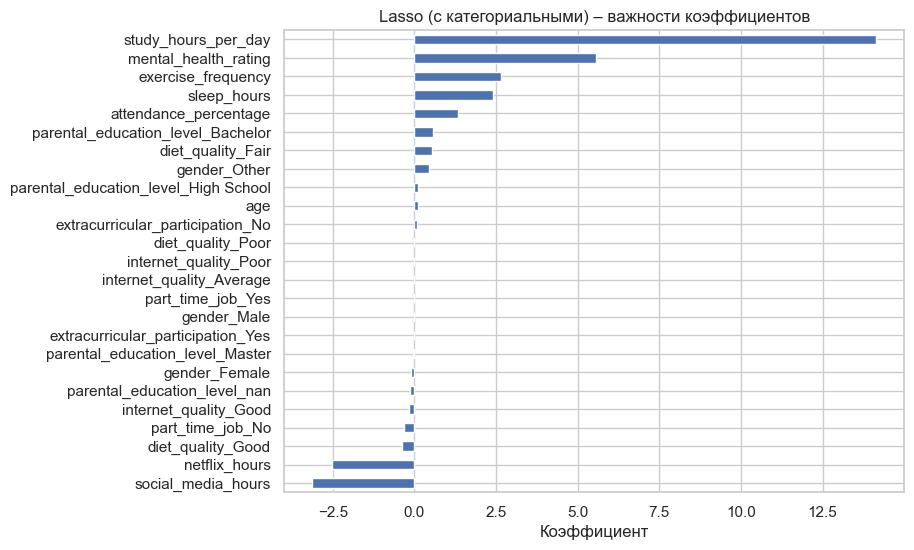

In [29]:
# Определим лучшую модель по R²
best_model_data = max(reports_stage2, key=lambda d: d['R2'])
best_pipe = best_model_data['model']
best_name = best_model_data['name']
print(f'\nЛучшая модель (этап 2): {best_name}')

# Получим имена признаков после One‑Hot кодирования
feature_names_num = numeric_features
ohe = best_pipe.named_steps['preprocess'].named_transformers_['cat']
feature_names_cat = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

coef = best_pipe.named_steps['model'].coef_
coef_series = pd.Series(coef, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, max(6, len(coef_series)//4)))
coef_series.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title(f'{best_name} (с категориальными) – важности коэффициентов')
plt.xlabel('Коэффициент')
plt.show()



Metrics after RFE (LinearRegression):
MSE : 26.508
MAE : 4.196
R^2 : 0.897


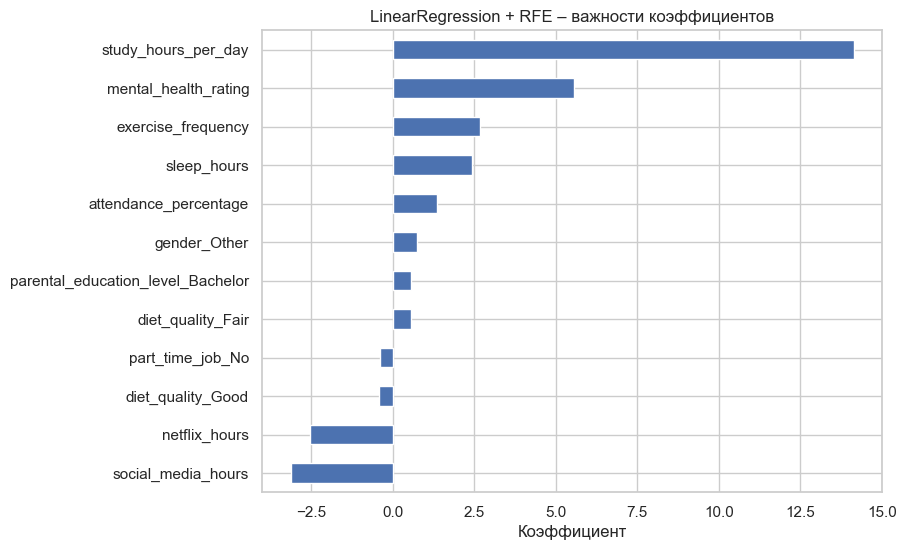

In [30]:
# ===== RFE =====
# Выберем 50 % признаков
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=int(len(feature_names)*0.5))
X_train_enc = best_pipe.named_steps['preprocess'].fit_transform(X_train_full)
X_test_enc  = best_pipe.named_steps['preprocess'].transform(X_test_full)

rfe_selector.fit(X_train_enc, y_train)
support_mask = rfe_selector.get_support()

# Обучим модель на отобранных признаках
X_train_rfe = X_train_enc[:, support_mask]
X_test_rfe  = X_test_enc[:, support_mask]

lin_rfe = LinearRegression()
lin_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = lin_rfe.predict(X_test_rfe)
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
mae_rfe = mean_absolute_error(y_test, y_pred_rfe)
r2_rfe  = r2_score(y_test, y_pred_rfe)

print('\nMetrics after RFE (LinearRegression):')
print(f'MSE : {mse_rfe:.3f}')
print(f'MAE : {mae_rfe:.3f}')
print(f'R^2 : {r2_rfe:.3f}')

# Важности
selected_features = feature_names[support_mask]
coef_rfe_series = pd.Series(lin_rfe.coef_, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(8, max(6, len(coef_rfe_series)//4)))
coef_rfe_series.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('LinearRegression + RFE – важности коэффициентов')
plt.xlabel('Коэффициент')
plt.show()


## Выводы

| Этап  | Признаки в модели                   | Лучшая модель                  | Параметры      | MSE ↓      | MAE ↓     | R² ↑      |
| ----- | ----------------------------------- | ------------------------------ | -------------- | ---------- | --------- | --------- |
| **1** | **только числовые**                 | **Lasso**                      | `alpha = 0.01` | **25.927** | **4.131** | **0.899** |
|       | Ridge                               | `alpha ≈ 1.27`                 | 25.940         | 4.132      | 0.899     |           |
|       | ElasticNet                          | `alpha = 0.01, l1_ratio = 0.9` | 25.938         | 4.132      | 0.899     |           |
| **2** | числовые + категориальные (One-Hot) | Lasso                          | `alpha = 0.01` | 26.449     | 4.185     | 0.897     |
|       | LinearRegression                    | —                              | 26.476         | 4.189      | 0.897     |           |
|       | Ridge                               | `alpha ≈ 1.27`                 | 26.492         | 4.190      | 0.897     |           |
|       | ElasticNet                          | `alpha = 0.01, l1_ratio = 0.9` | 26.462         | 4.186      | 0.897     |           |


Выбор лучшей модели
Без категориальных признаков: Lasso (R² ≈ 0.899).

С категориальными: также Lasso, но качество слегка хуже (R² ≈ 0.897).

Вывод — One-Hot-закодированные категориальные признаки практически не добавили новой информации и даже внесли небольшое «шумовое» ухудшение.



| Признак                    | Знак / влияние                                            |
| -------------------------- | --------------------------------------------------------- |
| **study\_hours\_per\_day** | **+** ≈ 15 – самый сильный позитивный вклад в performance |
| **mental\_health\_rating** | + ≈ 5 – лучшее самочувствие → выше успеваемость           |
| **exercise\_frequency**    | + ≈ 2.6                                                   |
| **sleep\_hours**           | + ≈ 2.4                                                   |
| **attendance\_percentage** | + ≈ 0.9                                                   |
| **age**                    | ≈ 0 (нейтрально)                                          |
| **netflix\_hours**         | **–** ≈ 2.5                                               |
| **social\_media\_hours**   | **–** ≈ 3.0                                               |


| Модель                              | # признаков | MSE        | MAE       | R²        |
| ----------------------------------- | ----------- | ---------- | --------- | --------- |
| **LinearRegression (все признаки)** | 40 – 45     | **26.476** | **4.189** | **0.897** |
| **LinearRegression + RFE**          | **12**      | 26.508     | 4.196     | 0.897     |


| Позитивный вклад ↑                                                | Негативный вклад ↓                                    |
| ----------------------------------------------------------------- | ----------------------------------------------------- |
| **study\_hours\_per\_day** (≈ +15) – главный драйвер успеваемости | **social\_media\_hours** (≈ –3)                       |
| mental\_health\_rating                                            | netflix\_hours                                        |
| exercise\_frequency                                               | —                                                     |
| sleep\_hours                                                      | —                                                     |
| attendance\_percentage                                            | —                                                     |
| gender\_Other (неожиданный, но маленький коэффициент)             | —                                                     |
| parental\_education\_level\_Bachelor                              | —                                                     |
| diet\_quality\_Fair                                               | diet\_quality\_Good (похоже на кодировочный артефакт) |
| part\_time\_job\_No                                               | —                                                     |


RFE упростил модель, удалив ≈ 70 % признаков — при этом качество
практически не изменилось.
→ имеет смысл, если важна интерпретируемость либо требуется сократить число атрибутов для сбора.

Ключевые факторы успеваемости остались теми же, что и в полной модели:
больше учебных часов, хороший сон, спорт, психическое здоровье, посещаемость.
Время в соцсетях и Netflix — отрицательные.

Если максимальная точность критична, можно оставить полную модель;
если важна компактность — RFE-вариант отлично подходит.

